# Clone data

In [2]:
!git clone https://github.com/pratyakshajha/Bird-Indentification-by-Audio.git

Cloning into 'Bird-Indentification-by-Audio'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 253 (delta 5), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (253/253), 161.79 MiB | 11.57 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (246/246), done.


In [0]:
# Change working directory 

import os
os.chdir("Bird-Indentification-by-Audio")

# Explore Audio and Save Spectrograms


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import os, random
import IPython

audio_file = 'data/coppersmith_barbet/' + random.choice(os.listdir('data/coppersmith_barbet'))
IPython.display.Audio(audio_file)

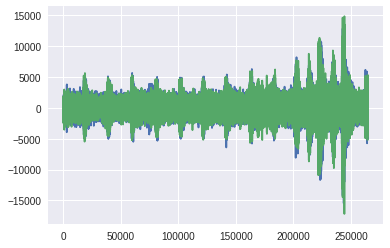

In [7]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

rate, data = wav.read(audio_file)

plt.plot(data)
plt.show()

In [0]:
def stereoToMono(audiodata):
  mono_audio = []
  
  for i in range(len(audiodata)):
        data = (audiodata[i][0]/2 + audiodata[i][1]/2)
        mono_audio.append(data)

  return np.array(mono_audio, dtype='int16')

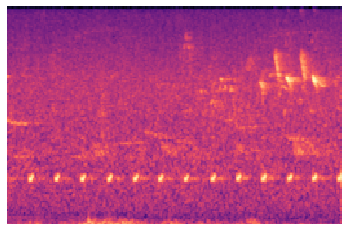

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np

def plotSpectrogram(audio_file):
  samples, sample_rate = librosa.load(audio_file)
  fig = plt.figure()
  S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

plotSpectrogram(audio_file)

In [10]:
!rm -r data/spectrograms
!mkdir data/spectrograms 
!mkdir data/spectrograms/coppersmith_barbet
!mkdir data/spectrograms/common_kingfisher

rm: cannot remove 'data/spectrograms': No such file or directory


In [0]:
def saveSpectrograms(readFolder, writeFolder):
  for i, audio in enumerate(os.listdir(readFolder)):
    audio_file = readFolder + '/' + audio
    samples, sample_rate = librosa.load(audio_file)
    fig = plt.figure()
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))    
    fig.savefig(writeFolder+'/'+'img_{0:03d}.jpg'.format(i), bbox_inches='tight', pad_inches = 0)
    plt.close(fig) 

saveSpectrograms('data/coppersmith_barbet', 'data/spectrograms/coppersmith_barbet')
saveSpectrograms('data/coppersmith_barbet', 'data/spectrograms/common_kingfisher')

In [0]:
import os, random

def scan_folder(parent, count):
    current_path = parent
    num_folders = len(os.listdir(parent))
    # iterate over all the files in directory 'parent'
    count = count if num_folders >= count else num_folders
    for file_name in random.sample(os.listdir(parent), count):   
        if file_name.endswith(".jpg"):                       
            print(parent+'/'+file_name) 
            img = plt.imread(parent+'/'+file_name)        
            plt.axis('off')
            plt.imshow(img)
            plt.show()
        else:
            current_path = "".join((parent, "/", file_name))
            if os.path.isdir(current_path):
                # if we're checking a sub-directory, recall this method
                print('Folder changed to: {}'.format(current_path))  
                scan_folder(current_path)
    else:
      print('error')

data/spectrograms/coppersmith_barbet/img_095.jpg


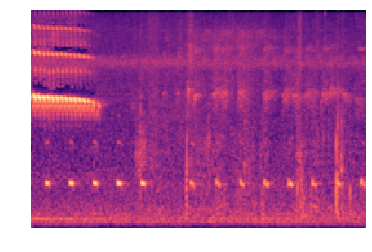

data/spectrograms/coppersmith_barbet/img_106.jpg


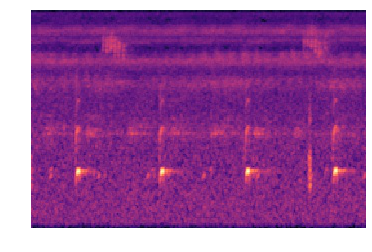

data/spectrograms/coppersmith_barbet/img_014.jpg


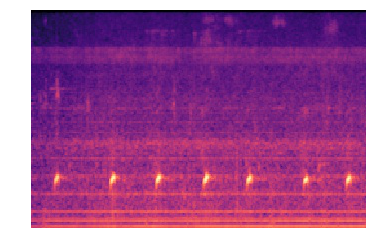

data/spectrograms/coppersmith_barbet/img_024.jpg


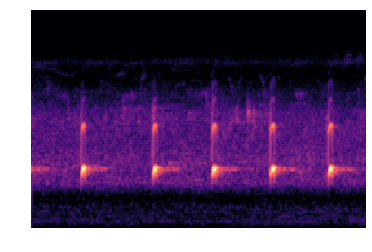

data/spectrograms/coppersmith_barbet/img_085.jpg


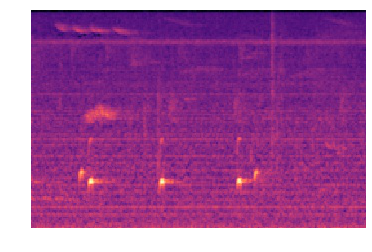

error


In [13]:
scan_folder('data/spectrograms/coppersmith_barbet', 5)

# Training

In [0]:
from fastai import *
from fastai.vision import *

In [15]:
path = Path('data/spectrograms')
path.ls()

[PosixPath('data/spectrograms/coppersmith_barbet'),
 PosixPath('data/spectrograms/common_kingfisher')]

In [0]:
classes = ['common_kingfisher', 'coppersmith_barbet']

In [17]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

common_kingfisher


coppersmith_barbet


In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=224, num_workers=4).normalize(imagenet_stats)

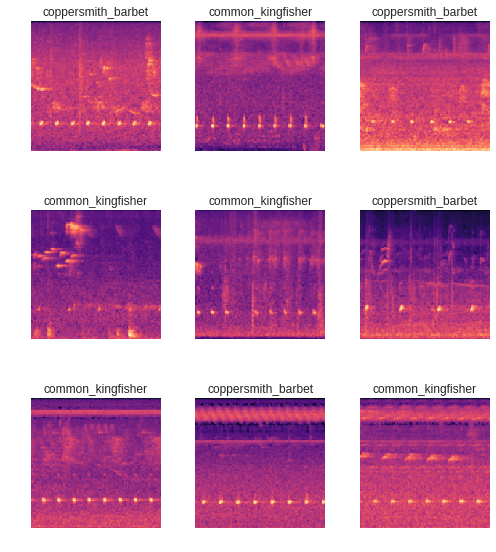

In [20]:
data.show_batch(rows=3, figsize=(7,8))

## Training: resnet50

Start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. 

We will train for 5 epochs (5 cycles through all our data).

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


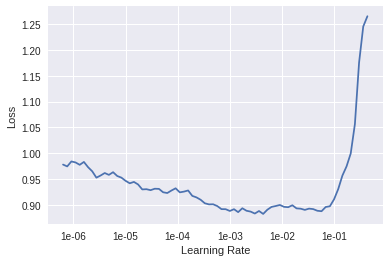

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.044373,0.716590,0.477273
2,1.099060,0.723399,0.522727
3,1.063597,0.743726,0.522727
4,1.030944,0.766514,0.522727
5,0.980666,0.810184,0.568182


In [0]:
learn.save('model')

## Interpretation

In [45]:
learn.load('model')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (180 items)
[Category coppersmith_barbet, Category coppersmith_barbet, Category coppersmith_barbet, Category coppersmith_barbet, Category coppersmith_barbet]...
Path: data/spectrograms
x: ImageItemList (180 items)
[Image (3, 217, 334), Image (3, 217, 334), Image (3, 217, 334), Image (3, 217, 334), Image (3, 217, 334)]...
Path: data/spectrograms;

Valid: LabelList
y: CategoryList (44 items)
[Category coppersmith_barbet, Category coppersmith_barbet, Category common_kingfisher, Category common_kingfisher, Category common_kingfisher]...
Path: data/spectrograms
x: ImageItemList (44 items)
[Image (3, 217, 334), Image (3, 217, 334), Image (3, 217, 334), Image (3, 217, 334), Image (3, 217, 334)]...
Path: data/spectrograms;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

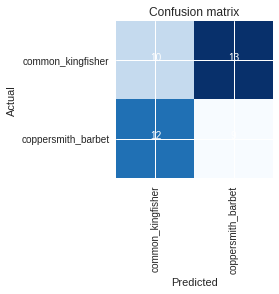

In [47]:
interp.plot_confusion_matrix()